<pre><b><h3>Basic Workflow of the Notebook</h3></b>
<h4>1. Feature Engineering</h4> 
        1.1 Static Data Analysis & Imputation
        1.2 Temporal Data Analysis
        1.3 Feature Extraction from Temporal Data & Imputation 
        1.4 Generation of .csv ( contains above three steps ) 
<h4>2. Model Deployment</h4>
        2.1 Classification Model 
        2.2 Sensitivity and Specifity Analysis
        2.3 Regression Model and mean RMSE
</pre>

In [111]:
import random
import numpy as np
import pandas as pd
import os

#-----Plotting
import matplotlib.pyplot as plt
import seaborn as sns

#-----Pre-processing
from sklearn.preprocessing import Imputer, StandardScaler,OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest,chi2,VarianceThreshold
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import TruncatedSVD

#-----Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, train_test_split,RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LogisticRegression

#-----Metrics
from sklearn.metrics import roc_auc_score, precision_score, recall_score, confusion_matrix, roc_curve, auc,accuracy_score
from sklearn.metrics import mean_squared_error

#-----Scipy
from scipy import stats

#-----For ignoring warnings
import warnings
warnings.filterwarnings("ignore")

In [112]:
static_feat = ['RecordID', 'Age', 'Gender', 'Height', 'ICUType', 'Weight'] 
temporal_feat = ['Albumin',       #----- (g/dL)
                'ALP',            #----- [Alkaline phosphatase (IU/L)]
                'ALT',            #----- [Alanine transaminase (IU/L)]
                'AST',            #----- [Aspartate transaminase (IU/L)]
                'Bilirubin',      #----- (mg/dL)
                'BUN',            #----- [Blood urea nitrogen (mg/dL)]
                'Cholesterol',    #----- (mg/dL)
                'Creatinine',     #----- [Serum creatinine (mg/dL)]
                'DiasABP',        #----- [Invasive diastolic arterial blood pressure (mmHg)]
                'FiO2',           #----- [Fractional inspired O2 (0-1)]
                'GCS',            #----- [Glasgow Coma Score (3-15)]
                'Glucose',        #----- [Serum glucose (mg/dL)]
                'HCO3',           #----- [Serum bicarbonate (mmol/L)]
                'HCT',            #----- [Hematocrit (%)]
                'HR',             #----- [Heart rate (bpm)]
                'K',              #----- [Serum potassium (mEq/L)]
                'Lactate',        #----- (mmol/L)
                'Mg',             #----- [Serum magnesium (mmol/L)]
                'MAP',            #----- [Invasive mean arterial blood pressure (mmHg)]
                'MechVent',       #----- [Mechanical ventilation respiration (0:false, or 1:true)]
                'Na',             #----- [Serum sodium (mEq/L)]
                'NIDiasABP',      #----- [Non-invasive diastolic arterial blood pressure (mmHg)]
                'NIMAP',          #----- [Non-invasive mean arterial blood pressure (mmHg)]
                'NISysABP',       #----- [Non-invasive systolic arterial blood pressure (mmHg)]
                'PaCO2',          #----- [partial pressure of arterial CO2 (mmHg)]
                'PaO2',           #----- [Partial pressure of arterial O2 (mmHg)]
                'pH',             #----- [Arterial pH (0-14)]
                'Platelets',      #----- (cells/nL)
                'RespRate',       #----- [Respiration rate (bpm)]
                'SaO2',           #----- [O2 saturation in hemoglobin (%)]
                'SysABP',         #----- [Invasive systolic arterial blood pressure (mmHg)]
                'Temp',           #----- [Temperature (°C)]
                'TroponinI',      #----- [Troponin-I (μg/L)]
                'TroponinT',      #----- [Troponin-T (μg/L)]
                'Urine',          #----- [Urine output (mL)]
                'WBC',            #----- [White blood cell count (cells/nL)]
                'Weight']         #----- (kg)

<center><pre><h5>File Read </h5></pre></center>

In [132]:
#folder = "set-a"
folder = r"predictingChallenge2012\set-a"  #Change folder location
doc = []
count = 0

#----- pre-processing (files - list)
for f in os.listdir(folder):                      #----- Iterate over list of files present in folder
    with open(os.path.join(folder,f),'r') as fp:  
        lines = fp.readlines()
    count = count+1
    record_id = lines[1].strip().split(',')[-1]   #----- getting record_id
    doc_dummy = [i.strip().split(',') + [(record_id)] for i in lines]
    doc.extend(doc_dummy[1:])



<center><pre><h5>Static Data Analysis & Imputation - Plotting and Extraction of Static Data recorded at Time 00:00 </pre></center>

No handles with labels found to put in legend.



1.1) Parameters recorded at time 00:00


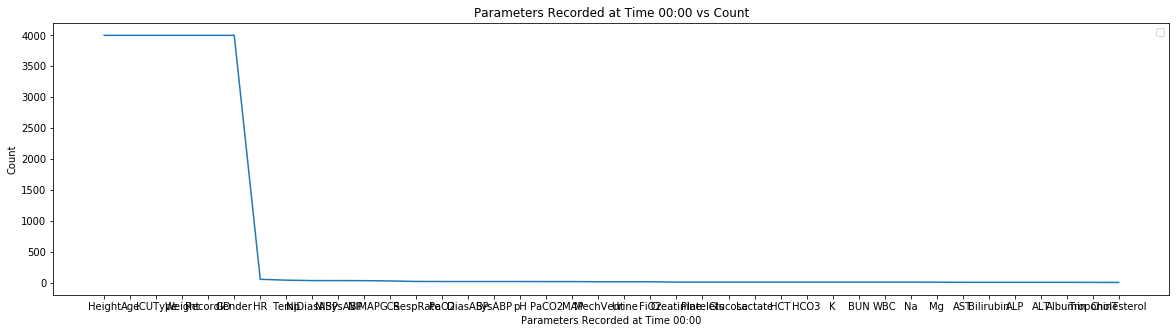

No handles with labels found to put in legend.



1.2) Extracting Static Features alone at Time 00:00


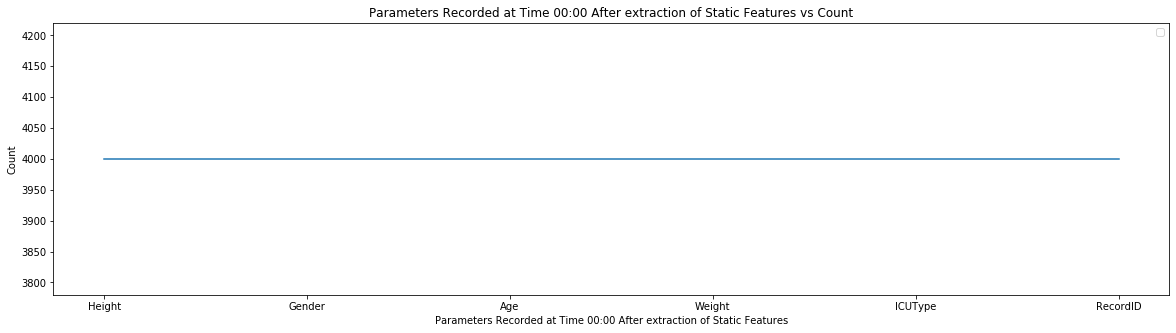


1.3) Number of observations of Static Data

(4000, 6)


Parameter,Age,Gender,Height,ICUType,RecordID,Weight
Record_ID,,,,,,
132539,54,0,-1,4,132539,-1
132540,76,1,175.3,2,132540,76
132541,44,0,-1,3,132541,56.7
132543,68,1,180.3,3,132543,84.6
132545,88,0,-1,3,132545,-1


In [145]:
#----- pre-processing (list - dataframe)
df = pd.DataFrame(doc,columns=['Time','Parameter','Value','Record_ID'])
df_static = df.loc[df['Time'] =='00:00']



print("\n1.1) Parameters recorded at time 00:00")
plt.figure(9,figsize = (20,5))
plt.plot(df_static['Parameter'].value_counts())
plt.xlabel("Parameters Recorded at Time 00:00")
plt.ylabel("Count")
plt.title("Parameters Recorded at Time 00:00 vs Count")
plt.legend()
plt.show()



#----- Ensure each patient has only one 'RecordID', 'Age', 'Gender', 'Height', 'ICUType', 'Weight'
df_static = df_static.loc[df_static['Parameter'].isin(static_feat)]
print("\n1.2) Extracting Static Features alone at Time 00:00")
plt.figure(9,figsize = (20,5))
plt.plot(df_static['Parameter'].value_counts())
plt.xlabel("Parameters Recorded at Time 00:00 After extraction of Static Features")
plt.ylabel("Count")
plt.title("Parameters Recorded at Time 00:00 After extraction of Static Features vs Count")
plt.legend()
plt.show()



df = df.loc[~df.index.isin(df_static.index)]      #----- Removing static variables from Temporal Data in df 
df_static = df_static.pivot(index='Record_ID', columns='Parameter', values='Value')
print("\n1.3) Number of observations of Static Data\n")
print(df_static.shape)
df_static.head()

In [148]:
df_static.info()

df_static

<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 132539 to 142673
Data columns (total 7 columns):
Age          4000 non-null float64
Gender       4000 non-null float64
Height       4000 non-null float64
ICUType      4000 non-null float64
RecordID     4000 non-null float64
Weight       4000 non-null float64
age_group    4000 non-null category
dtypes: category(1), float64(6)
memory usage: 223.0+ KB


Parameter,Age,Gender,Height,ICUType,RecordID,Weight,age_group
Record_ID,,,,,,,
132539,54.0,0.0,-1.0,4.0,132539.0,-1.0,50-60
132540,76.0,1.0,175.3,2.0,132540.0,76.0,70-80
132541,44.0,0.0,-1.0,3.0,132541.0,56.7,40-50
132543,68.0,1.0,180.3,3.0,132543.0,84.6,60-70
132545,88.0,0.0,-1.0,3.0,132545.0,-1.0,80-90
132547,64.0,1.0,180.3,1.0,132547.0,114.0,60-70
132548,68.0,0.0,162.6,3.0,132548.0,87.0,60-70
132551,78.0,0.0,162.6,3.0,132551.0,48.4,70-80
132554,64.0,0.0,-1.0,3.0,132554.0,60.7,60-70


<pre><h5>Static Data Exploration for Imputation - Plotting of</h5>

    1. Gender vs Count
    2. Age Vs Count
    3. Height & Weight based on its age-group vs Count

<h5>Static data</h5>
    1. RecordID (a unique integer for each ICU stay)
    2. Age (years)
    3. Gender (0: female, or 1: male)
    4. Height (cm)
    5. ICUType (1: Coronary Care Unit, 2: Cardiac Surgery Recovery Unit,3: Medical ICU, or 4: Surgical ICU)
    6. Weight (kg)

</pre>

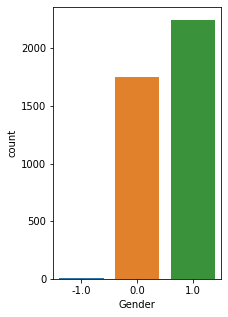

 1.0    2246
 0.0    1751
-1.0       3
Name: Gender, dtype: int64


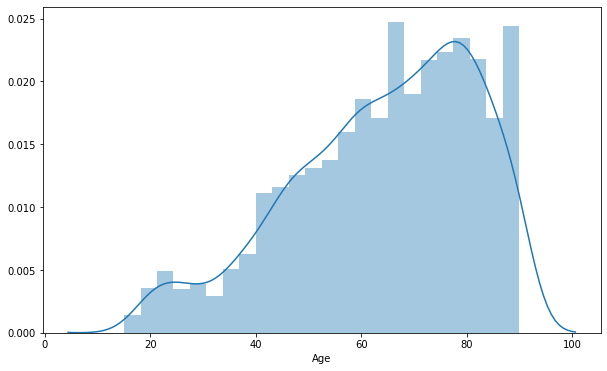

<Figure size 1080x432 with 0 Axes>

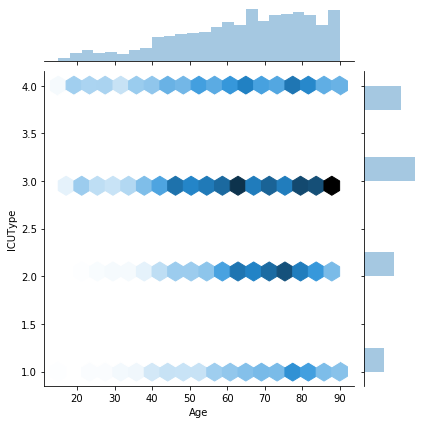

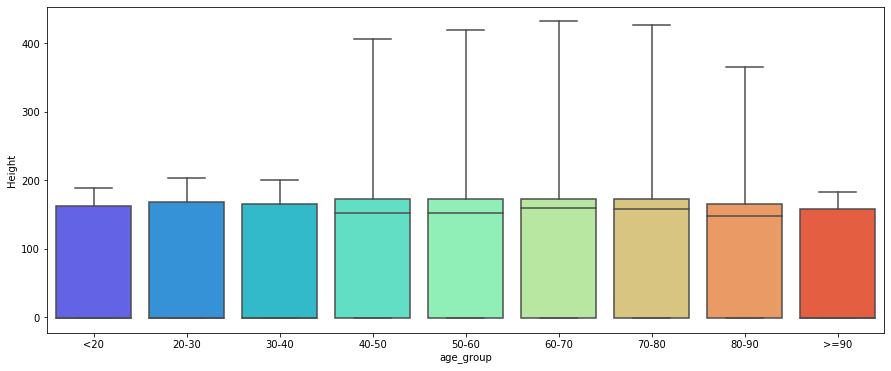

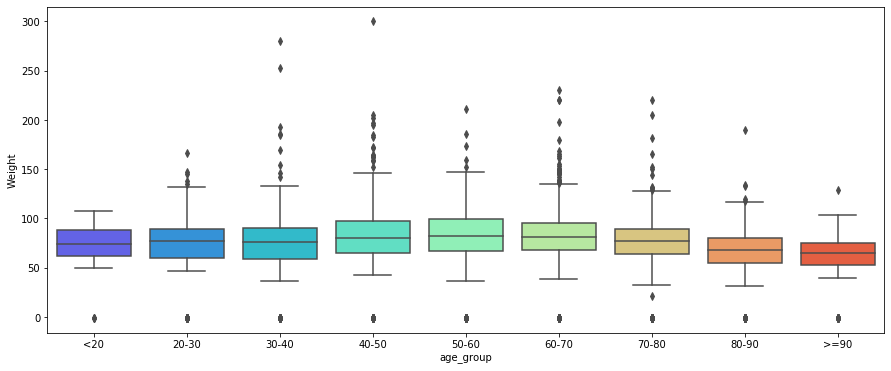

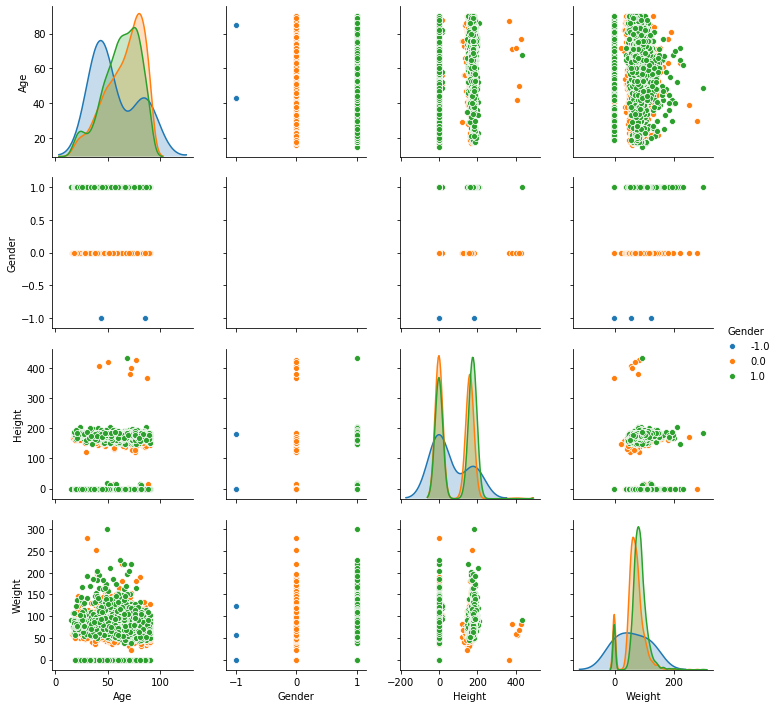

In [147]:
#----- converting static into numeric
df_static = df_static.astype(float)

#----- Grouping Height, Weight based on the age-group for imputation
df_static['age_group'] = pd.cut(df_static.Age, [0, 20, 30, 40, 50, 60, 70, 80, 90,float('Inf')], right=False, labels=["<20", "20-30", "30-40","40-50","50-60","60-70","70-80","80-90",">=90"])


df_static_viz = df_static.reset_index(drop=True)

#----- Analysis of Gender data for imputation
plt.figure(figsize = (3,5))
sns.countplot(x='Gender',data=df_static_viz)
plt.show()

print(df_static['Gender'].value_counts())

#----- Analysis of Age data for imputation
plt.figure(9,figsize = (10,6))
sns.distplot(df_static_viz['Age'])
plt.show()

#ICUType vs Age
plt.figure(figsize = (15,6))
sns.jointplot(x='Age',y='ICUType',data=df_static_viz,kind='hex')
plt.show()

plt.figure(figsize = (15,6))
sns.boxplot(x="age_group", y="Height", data=df_static_viz,palette='rainbow')
plt.show()

plt.figure(figsize = (15,6))
sns.boxplot(x="age_group", y="Weight", data=df_static_viz,palette='rainbow')
plt.show()


df_static_pairplot = df_static_viz.drop(['RecordID','age_group','ICUType'],axis =1)
sns.pairplot(df_static_pairplot,hue='Gender')

<pre>
<h6> Observations from the plots</h6>

1. Gender has 3 negative that is missing values.

2. The Histogram for ages is plotted to find the distribution of ages among the patients and it was observed that the maximum and the minimum values lie between 90 and 15 respectively, and majority of patients belong to the 60-90 age group.

3. ICUType vs Age jointplot shows that there are more patients in Medical ICU (ICUType 3) and patients above age 60 constitute the majority.

4. Box plots of Weight and Height are plotted against their age-group (interval of 10) to find the outliers and it was observed that there are missing values in both heights and weights, in addition to that, uncommon values are also present which has to be handled.

</pre>

<pre><h5>Static Data Analysis & Imputation - Handling Uncommon and Missing Values</h5></pre>

In [149]:
#-----Handling the missing and incorrect values in the static data 

#-----Finding the most frequent values (mode) to impute the missing data.
gender_mode = float(df_static['Gender'].mode())
ICUType_mode = float(df_static['ICUType'].mode())

#-----Finding the average (mean) of these columns to impute the missing data.
age_avg = float(df_static['Age'].mean())
weight_avg = float(df_static['Weight'].mean())
height_avg = float(df_static['Height'].mean())

for c in df_static:
    x = df_static[c]
    #-----'Age' greater than 100 is considered abnormal, such values are imputed with 91.4 (max_value)
    if c == 'Age':
        idx = x > 100
        df_static.loc[idx,c] = 91.4       
    
    #----'Gender' a binary column can have only values 0 and 1. If anyother number is present,then we impute with mode.
    if c == 'Gender':
        idx = x < 0
        df_static.loc[idx, c] = gender_mode
       
        idx = x > 1
        df_static.loc[idx, c] = gender_mode
    #----'Weight' has a nominal range between 35 and 300.Anything outer this region is considered abnormal and imputed
   #with mean value.  
    elif c == 'Weight':
        idx = x < 35
        df_static.loc[idx, c] = weight_avg
       
        idx = x > 300
        df_static.loc[idx, c] = weight_avg
    
    #-----'Height' imputation. 
    elif c == 'Height':
        idx = x < 0
        df_static.loc[idx,c] = height_avg
        
        idx = x < 10          #---- '10' is too little a value for height and it must be wrongly entered.To make it reliable we multiply with 100.
        df_static.loc[idx, c] = df_static.loc[idx, c] * 100
       
        idx = x < 25          #----- 18 -> 180 (The same condition as above applies for this)
        df_static.loc[idx, c] = df_static.loc[idx, c] * 10
       
        idx = x < 100         #----- 81.8 -> 180 (inch -> cm) For converting units from inches to cm
        df_static.loc[idx, c] = df_static.loc[idx, c] * 2.2
       
        idx = x > 1000        #----- 1800 -> 180 Any value greater than 1000 is too large to be height, so minimizing by multiplying with 0.1.
        df_static.loc[idx, c] = df_static.loc[idx, c] * 0.1
       
        idx = x > 250         #----- 400 -> 157 Same condition as above.
        df_static.loc[idx, c] = df_static.loc[idx, c] * 0.3937
    
    #----'ICU Type' a categorical column. If anyother number other than 1,2,3,4 is present,then we impute with mode.  
    elif c == 'ICUType':
        idx = x < 1
        df_static.loc[idx, c] = ICUType_mode
       
        idx = x > 4
        df_static.loc[idx,c]= ICUType_mode

In [150]:
#----- One-hot Encoding for Categorical Feature (ICUType)

df_static = df_static.join(pd.get_dummies(df_static['ICUType'], prefix='ICUType')) 
df_static.drop(['ICUType'],axis =1,inplace=True)
df_static.drop(['age_group'],axis =1,inplace=True)
df_static.head()

,Age,Gender,Height,RecordID,Weight,ICUType_1.0,ICUType_2.0,ICUType_3.0,ICUType_4.0
Record_ID,,,,,,,,,
132539,54.0,0.0,195.622845,132539.0,74.75629,0,0,0,1
132540,76.0,1.0,175.300000,132540.0,76.00000,0,1,0,0
132541,44.0,0.0,195.622845,132541.0,56.70000,0,0,1,0
132543,68.0,1.0,180.300000,132543.0,84.60000,0,0,1,0
132545,88.0,0.0,195.622845,132545.0,74.75629,0,0,1,0


<pre><h5>                                  Temporal Data Analysis</h5></pre>

In [151]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1733980 entries, 6 to 1757979
Data columns (total 4 columns):
Time         object
Parameter    object
Value        object
Record_ID    object
dtypes: object(4)
memory usage: 66.1+ MB


<pre><h5>Temporal Data Analysis - Plotting Temporal Data to find Measurement Frequency</h5></pre>

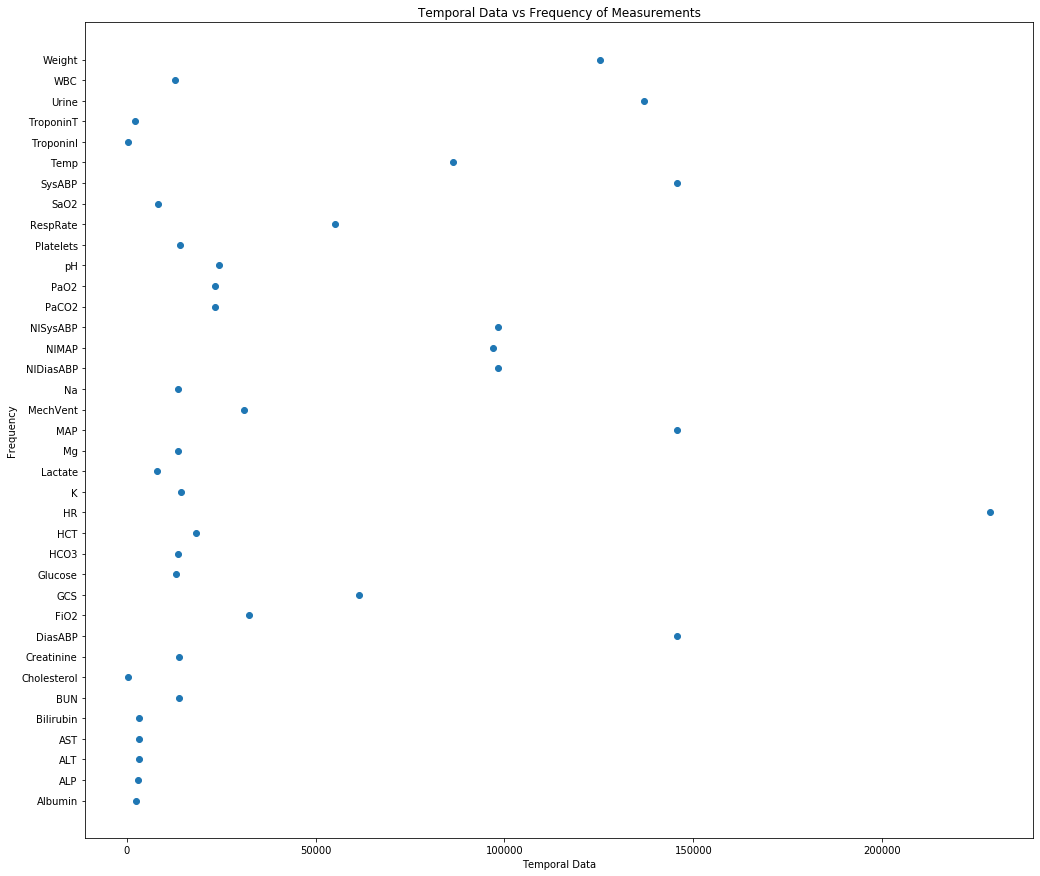

In [152]:
#----- Feature Engineering for Temporal Data
df['Value'] = df['Value'].astype('float')


#----- Grouping based on the record_id
grp = df.groupby('Record_ID')


dummy = pd.DataFrame(columns=temporal_feat)
dummy.loc[0] = [0 for i in range(37)]

for i in grp.groups.keys():
    x=grp.get_group(i)['Parameter'].value_counts()
    dummy[x.index]  += x
    
    
plt.figure(9,figsize = (17,15))
plt.scatter(dummy.loc[0],temporal_feat)
plt.xlabel("Temporal Data")
plt.ylabel("Frequency")
plt.title("Temporal Data vs Frequency of Measurements")
plt.show()

<html>
    <pre><h6> Observations from the plots</h6></pre>
    <pre>
    1. Based on the above group, the following temporal data are measured frequently than other temporal data:
    </pre>
    <table>
         <tr>
             <th> Urine </th>
             <th> Temp </th>
             <th> SysABP </th>
             <th> SaO2 </th>
             <th> RespRate </th>
             <th> NISysABP </th>
             <th> NIMAP </th>
             <th> NIDiasABP </th>
             <th> MAP </th>
             <th> HR </th>
             <th> GCS </th>
             <th> DiasABP </th>
        </tr>   
    </table>
    <pre>
    2. So, <b>First,Last,Min,Max</b> Measurements of the above preceded temporal features are extracted to predict mortality rate and lenght of the stay.
    3. And for the remainining temporal features,<b>First and Last values</b> are extracted 
    </pre>  
</html>

In [153]:
#----- Temporal features, recorded with higher frequency
temporal_feat_1 = ['DiasABP', 'GCS', 'HR', 'MAP','NIDiasABP', 'NIMAP',
                   'NISysABP', 'RespRate', 'SaO2', 'Temp','Urine' ]
df_tmp = df.loc[df['Parameter'].isin(temporal_feat_1)]
df_tmp = df_tmp.groupby(['Record_ID', 'Parameter'])['Value']

X = df_static.copy()

#----- Getting First, Last, Min and Max for temporal features recorded with higher frequency
for i in ['First','Last','Min','Max']:
    if(i=='First'):
        X_tmp = df_tmp.first()
    elif(i=='Last'):
        X_tmp = df_tmp.last()
    elif(i=='Min'):
        X_tmp = df_tmp.min()
    elif(i=='Max'):
        X_tmp = df_tmp.max()
        
#----- Changing patient records to rows 
    X_tmp = X_tmp.reset_index()
    X_tmp = X_tmp.pivot(index='Record_ID',columns='Parameter',values='Value')
    X_tmp.columns = [j + '_' + i for j in X_tmp.columns]
    
#----- Adding Temporal features with static
    X = X.merge(X_tmp, how='left' , left_index=True, right_index=True )

X.head()

,Age,Gender,Height,RecordID,Weight,ICUType_1.0,ICUType_2.0,ICUType_3.0,ICUType_4.0,DiasABP_First,...,GCS_Max,HR_Max,MAP_Max,NIDiasABP_Max,NIMAP_Max,NISysABP_Max,RespRate_Max,SaO2_Max,Temp_Max,Urine_Max
Record_ID,,,,,,,,,,,,,,,,,,,,,
132539,54.0,0.0,195.622845,132539.0,74.75629,0,0,0,1,NaN,...,15.0,86.0,NaN,67.0,92.33,157.0,24.0,NaN,38.2,900.0
132540,76.0,1.0,175.300000,132540.0,76.00000,0,1,0,0,67.0,...,15.0,90.0,100.0,67.0,88.33,131.0,NaN,99.0,37.9,770.0
132541,44.0,0.0,195.622845,132541.0,56.70000,0,0,1,0,81.0,...,8.0,113.0,107.0,95.0,110.00,150.0,NaN,95.0,39.0,425.0
132543,68.0,1.0,180.300000,132543.0,84.60000,0,0,1,0,NaN,...,15.0,88.0,NaN,81.0,100.70,140.0,24.0,NaN,37.0,700.0
132545,88.0,0.0,195.622845,132545.0,74.75629,0,0,1,0,NaN,...,15.0,94.0,NaN,96.0,105.70,157.0,27.0,NaN,37.8,220.0


<pre><h5> Feature Extraction from Temporal Data - Temporal Features with Low Frequency Measurements </h5></pre>

In [154]:
#----- Temporal features, recorded with lower frequency
temporal_feat_2 = ['Albumin', 'ALP', 'ALT', 'AST', 'Bilirubin', 'BUN', 'Cholesterol','Creatinine', 'FiO2', 'HCO3', 
                   'HCT', 'K', 'Lactate', 'Mg', 'Na','PaCO2', 'PaO2', 'pH', 'Platelets', 'SysABP', 'TroponinI', 
                   'TroponinT','WBC']

df_tmp = df.loc[df['Parameter'].isin(temporal_feat_2)]
df_tmp = df_tmp.groupby(['Record_ID', 'Parameter'])['Value']

#----- Getting First, Last, Min and Max for temporal features recorded with lower frequency
for i in ['First','Last']:
    if(i=='First'):
        X_tmp = df_tmp.first()
    elif(i=='Last'):
        X_tmp = df_tmp.last()
        
#----- Changing patient records to rows 
    X_tmp = X_tmp.reset_index()
    X_tmp = X_tmp.pivot(index='Record_ID',columns='Parameter',values='Value')
    X_tmp.columns = [j + '_' + i for j in X_tmp.columns]
    
#----- Adding features with previously extracted ones
    X = X.merge(X_tmp, how='left' , left_index=True, right_index=True )

X.head()

,Age,Gender,Height,RecordID,Weight,ICUType_1.0,ICUType_2.0,ICUType_3.0,ICUType_4.0,DiasABP_First,...,Mg_Last,Na_Last,PaCO2_Last,PaO2_Last,Platelets_Last,SysABP_Last,TroponinI_Last,TroponinT_Last,WBC_Last,pH_Last
Record_ID,,,,,,,,,,,,,,,,,,,,,
132539,54.0,0.0,195.622845,132539.0,74.75629,0,0,0,1,NaN,...,1.9,136.0,NaN,NaN,185.0,NaN,NaN,NaN,9.4,NaN
132540,76.0,1.0,175.300000,132540.0,76.00000,0,1,0,0,67.0,...,1.9,135.0,46.0,140.0,135.0,103.0,NaN,NaN,13.3,7.37
132541,44.0,0.0,195.622845,132541.0,56.70000,0,0,1,0,81.0,...,1.7,138.0,37.0,173.0,113.0,126.0,NaN,NaN,6.2,7.47
132543,68.0,1.0,180.300000,132543.0,84.60000,0,0,1,0,NaN,...,1.9,137.0,NaN,NaN,284.0,NaN,NaN,NaN,7.9,NaN
132545,88.0,0.0,195.622845,132545.0,74.75629,0,0,1,0,NaN,...,1.6,139.0,NaN,NaN,97.0,NaN,NaN,NaN,4.8,NaN


In [155]:
print(X.shape)

(4000, 99)


<pre><h5> Feature Extraction from Temporal Data - Ploting of Mechanical Ventialtion (Temporal_Binary data)</h5></pre>
                                       
<pre>
Since <b>Mechanical Ventilation is a continous time value</b>, but it is indicated as YES or NO. So, the following code block shows the conversion of YES or NO (Binary) to Continuous Value using "Time" Feature
</pre>

<pre><i>To find ventilation is 

                           1. Continuously on
                           2. Continuously off
                           3. Switching between on and off
                                                         </i></pre>



Text(0, 0.5, 'Mechanical Ventilation Presence 1.0 /Absence 0.0 / Missing Values -1.0')

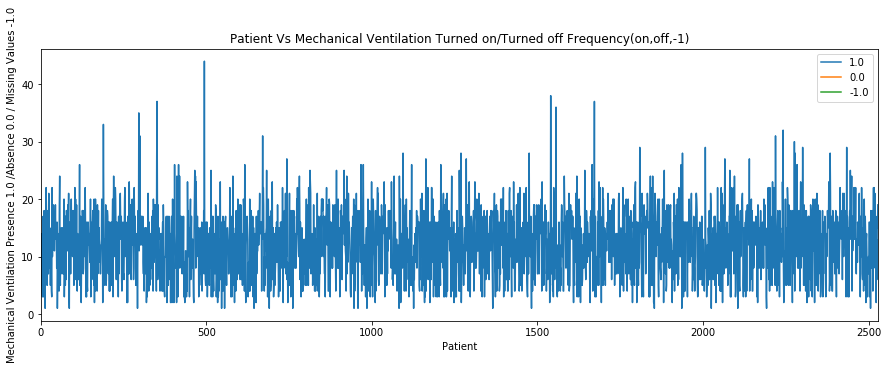

In [156]:
#----- Mechanical Ventilation YES or NO to Coninuous Value 
df_tmp = df.loc[df['Parameter']=="MechVent"]
df_tmp = df_tmp.groupby('Record_ID')

#----- Finding is if the ventilation is " on for sometimes and off for sometimes" ,
#-----                                  " continuously on" ,
#-----                                  " continuously off" 

interval = pd.DataFrame(columns = [1.0,0.0,-1])
count = 0
for i in df_tmp.groups.keys():          #------ Grouped based on RecordID
    interval.loc[count] = df_tmp.get_group(i)['Value'].value_counts()
    count = count+1
    
#interval = interval.T
interval.plot(figsize = (15,5), title = "Patient Vs Mechanical Ventilation Turned on/Turned off Frequency(on,off,-1)")
plt.xlabel("Patient")
plt.ylabel("Mechanical Ventilation Presence 1.0 /Absence 0.0 / Missing Values -1.0")

<html>
    <pre><h6> Observations from the plots</h6></pre>
    <pre
    From the above graph it is observed that the <b> Mechanical ventilation is always on </b> for ~2600 Patients and for the rest of the patient mechanical ventilation is not used
    </pre>
</html>

In [157]:
#----- Finding min and converting string 00:00 to hours format
start_time = df_tmp[['Time']].min()
start_time['Time'] = (start_time['Time'].str.split(':').str[0].astype(int))*60 + start_time['Time'].str.split(':').str[1].astype(int)
start_time.columns = ['VentilationStartTime']

#----- Adding Ventilation starting time is one of the features
X = X.merge(start_time, how='left', left_index=True, right_index=True)

#----- Finding max , converting string 00:00 to hours format , duration
time = df_tmp[['Time']].max()
time['Time'] = (time['Time'].str.split(':').str[0].astype(int))*60 + time['Time'].str.split(':').str[1].astype(int)
time['Time'] = time['Time'] - start_time['VentilationStartTime']
time.columns = ['duration']

#----- Adding Ventilation starting time is one of the features
X = X.merge(time, how='left', left_index=True, right_index=True)
print(X.shape)
X.head()

(4000, 101)


,Age,Gender,Height,RecordID,Weight,ICUType_1.0,ICUType_2.0,ICUType_3.0,ICUType_4.0,DiasABP_First,...,PaCO2_Last,PaO2_Last,Platelets_Last,SysABP_Last,TroponinI_Last,TroponinT_Last,WBC_Last,pH_Last,VentilationStartTime,duration
Record_ID,,,,,,,,,,,,,,,,,,,,,
132539,54.0,0.0,195.622845,132539.0,74.75629,0,0,0,1,NaN,...,NaN,NaN,185.0,NaN,NaN,NaN,9.4,NaN,NaN,NaN
132540,76.0,1.0,175.300000,132540.0,76.00000,0,1,0,0,67.0,...,46.0,140.0,135.0,103.0,NaN,NaN,13.3,7.37,71.0,360.0
132541,44.0,0.0,195.622845,132541.0,56.70000,0,0,1,0,81.0,...,37.0,173.0,113.0,126.0,NaN,NaN,6.2,7.47,617.0,2160.0
132543,68.0,1.0,180.300000,132543.0,84.60000,0,0,1,0,NaN,...,NaN,NaN,284.0,NaN,NaN,NaN,7.9,NaN,NaN,NaN
132545,88.0,0.0,195.622845,132545.0,74.75629,0,0,1,0,NaN,...,NaN,NaN,97.0,NaN,NaN,NaN,4.8,NaN,NaN,NaN


<pre><h5>1.3 Temporal Data Imputation - Handling Missing Values/Non-recorded parameters to 0 </h5></pre>

In [158]:
#----- Finding Number of records having NAN in each features
print(X.isna().sum())

#----- Finding Missing records in each features
for i in X:
    if( (X[i]<0).sum() > 0):
        print(i,(X[i]<0).sum())
        
#----- Replacing Missing values and NAN to 0
X = X.fillna(0)


Age                        0
Gender                     0
Height                     0
RecordID                   0
Weight                     0
ICUType_1.0                0
ICUType_2.0                0
ICUType_3.0                0
ICUType_4.0                0
DiasABP_First           1201
GCS_First                 64
HR_First                  63
MAP_First               1208
NIDiasABP_First          517
NIMAP_First              519
NISysABP_First           507
RespRate_First          2899
SaO2_First              2208
Temp_First                64
Urine_First              117
DiasABP_Last            1201
GCS_Last                  64
HR_Last                   63
MAP_Last                1208
NIDiasABP_Last           517
NIMAP_Last               519
NISysABP_Last            507
RespRate_Last           2899
SaO2_Last               2208
Temp_Last                 64
                        ... 
SysABP_First            1201
TroponinI_First         3795
TroponinT_First         3137
WBC_First     

<pre><h5>Writing Design Matrix to csv file</h5></pre>

<pre>Train.csv holds the data for design matrix 1 </pre>

In [159]:
X.to_csv("Train.csv")

<pre><h2>XGB Classification for "In-Hospital Death" Prediction </h2></pre>

<pre><h5>XGB Classification Model </h5></pre>
<pre>Model Parameters
            n_estimator = 550,
            min_child_weight = 5 obtained after randomized grid search over the entire dataset</pre>

In [160]:
Mean_auc = []
label = [[1,2,3,4],[1,2,4,3],[1,3,4,2],[2,3,4,1]]

#----- XGBClassifier 
#----- Iterating through all the folds in the below sequence

#Iteration 1:  Training data: fold 1, 2, 3, Test data: fold 4
#Iteration 2:  Training data: fold 1, 2, 4, Test data: fold 3
#Iteration 3:  Training data: fold 1, 3, 4, Test data: fold 2
#Iteration 4:  Training data: fold 4, 2, 3, Test data: fold 1

for i in range(0,4):            
    Y_train = pd.concat([pd.read_csv("Fold" + str(label[i][0]) + "_Outcomes.csv"),
                     pd.read_csv("Fold" + str(label[i][1])  + "_Outcomes.csv"),
                     pd.read_csv("Fold" + str(label[i][2]) + "_Outcomes.csv")])

    Y_test = pd.read_csv("Fold" + str(label[i][3]) + "_Outcomes.csv")
    
    X_train = pd.read_csv("Train.csv")
    
    #----- Load the matching records from Y_train (Record_ID) in X_train and unmatched records in X_test
        
    X_test = X_train.loc[~X_train['RecordID'].isin(Y_train['RecordID'])]
    X_train = X_train.loc[X_train['RecordID'].isin(Y_train['RecordID'])]
    #-------Dropping the insignificant features
    X_test.drop(['Record_ID','RecordID'],axis=1,inplace=True)
    X_train.drop(['Record_ID','RecordID'],axis=1,inplace=True)
    
    model = XGBClassifier(n_estimator = 550,min_child_weight=5)
    
    #------ In-hospital_death => Classifier target variable
    
    model.fit(X_train, Y_train['In-hospital_death'])
    Mean_auc.append(roc_auc_score(Y_test['In-hospital_death'],model.predict_proba(X_test)[:,1]))
    print("ROC_AUC Score Fold",label[i][3],"as Testing Data: ",Mean_auc[i])

print("Mean ROC_AUC Score",np.mean(Mean_auc))

ROC_AUC Score Fold 4 as Testing Data:  0.8517058486238532
ROC_AUC Score Fold 3 as Testing Data:  0.8483206933911159
ROC_AUC Score Fold 2 as Testing Data:  0.8522237025758151
ROC_AUC Score Fold 1 as Testing Data:  0.8436053240740742
Mean ROC_AUC Score 0.8489638921662146


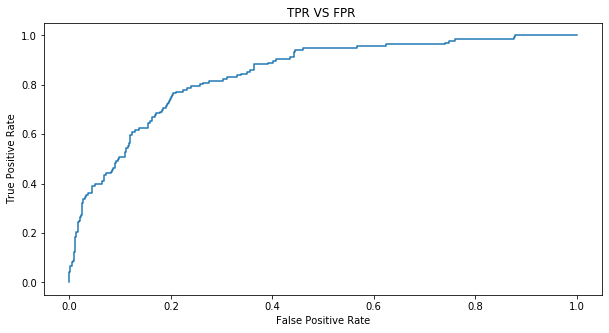

In [161]:
Y_pred = model.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(Y_test['In-hospital_death'] , Y_pred)

auc = roc_auc_score(Y_test['In-hospital_death'] , Y_pred)
plt.figure(9,figsize = (10,5))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("TPR VS FPR ")
plt.plot(fpr,tpr,label="data, auc="+str(auc))


<pre>
    1.From the above graph, Threshold value at the top left corner should be choosen such that False Positive is less at the same time True Positive is high.
    2. Since, we are dealing with Mortality prediction, False Positive should be as low as possible
</pre>

<pre><h2>XGB Regression for "Length of the Stay" Prediction</h2></pre>
<pre><h5>XGB Regressor With Scalar </h5></pre>
<pre>Model Parameters
            n_estimators=150, 
            max_depth=6, 
            subsample=0.6,
            learning_rate=0.03, 
            gamma=0, 
            colsample_bytree=0.3,
            silent=False, 
            objective="reg:linear" obtained after randomized grid search over the entire dataset</pre>

In [163]:
Mean_rms = []
label = [[1,2,3,4],[1,2,4,3],[1,3,4,2],[2,3,4,1]]
preprocesser = Pipeline(steps=[('scaler',StandardScaler())])

#----- XGBRegressor with scaler
#----- Iterating through all the folds in the below sequence

#Iteration 1:  Training data: fold 1, 2, 3, Test data: fold 4
#Iteration 2:  Training data: fold 1, 2, 4, Test data: fold 3
#Iteration 3:  Training data: fold 1, 3, 4, Test data: fold 2
#Iteration 4:  Training data: fold 4, 2, 3, Test data: fold 1

for i in range(0,4):            
    Y_train = pd.concat([pd.read_csv("Fold" + str(label[i][0]) + "_Outcomes.csv"),
                     pd.read_csv("Fold" + str(label[i][1])  + "_Outcomes.csv"),
                     pd.read_csv("Fold" + str(label[i][2]) + "_Outcomes.csv")])

    Y_test = pd.read_csv("Fold" + str(label[i][3]) + "_Outcomes.csv")
    
    X_train = pd.read_csv("Train.csv")
    
    #----- Load the matching records from Y_train (Record_ID) in X_train and unmatched records in X_test
    X_test = X_train.loc[~X_train['RecordID'].isin(Y_train['RecordID'])]
    X_train = X_train.loc[X_train['RecordID'].isin(Y_train['RecordID'])]
    
    #-------Dropping the insignificant features
    X_test.drop(['Record_ID','RecordID'],axis=1,inplace=True)
    X_train.drop(['Record_ID','RecordID'],axis=1,inplace=True)
    
    X_train_scaled = preprocesser.fit_transform(X_train,Y_train["Length_of_stay"])
    X_test_scaled = preprocesser.transform(X_test)
    
    
    reg_xgb = XGBRegressor(n_estimators=150, max_depth=6, subsample=0.6,learning_rate=0.03, gamma=0, 
                           colsample_bytree=0.3,silent=False, objective="reg:linear")
    reg_xgb.fit(X_train_scaled, Y_train["Length_of_stay"])
    Y_pred = reg_xgb.predict(X_test_scaled)
    Mean_rms.append(np.sqrt(mean_squared_error(Y_test["Length_of_stay"], Y_pred)))
    print("RMS Fold",label[i][3],"as Testing Data: ",Mean_rms[i])
    
print("\nMean RMS Score",np.mean(Mean_rms))


[07:38:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMS Fold 4 as Testing Data:  10.190987820572294
[07:38:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMS Fold 3 as Testing Data:  11.007219691107283
[07:38:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMS Fold 2 as Testing Data:  10.940765096467558
[07:39:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMS Fold 1 as Testing Data:  13.071284572229077

Mean RMS Score 11.302564295094053


<h3> End of Notebook </h3>